In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np

# Charger le dataset
california = fetch_california_housing()

# S´eparer les caract´eristiques et la variable cible
x, y = california.data, california.target

# Analyse des variables
df_data = pd.DataFrame(data=x, columns=california.feature_names)
# Ajouter la variable cible (prix)
df_data['target'] = california.target

# Vérification des valeurs manquantes
missing_values_percentage = (df_data.shape[0] - df_data.count()) / df_data.shape[0] * 100
print(missing_values_percentage)

# Separate features and target variable
X = df_data.drop(["target"], axis=1)
Y = df_data["target"]

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Mise en en place des modèles d'entrainements
# Initialize models
linear_reg = LinearRegression()
lasso_reg = Lasso()
random_forest_reg = RandomForestRegressor()

# Train models
linear_reg.fit(X_train, Y_train)
lasso_reg.fit(X_train, Y_train)
random_forest_reg.fit(X_train, Y_train)

# Make predictions
y_pred_linear = linear_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_rf = random_forest_reg.predict(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(Y_test, y_pred)
    print(f"{name}: R-squared (R^2) score: {r2*100:.2f}%")

# Select the best model
best_model_name = max(models, key=lambda x: r2_score(Y_test, models[x].predict(X_test)))
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
target        0.0
dtype: float64
Linear Regression: R-squared (R^2) score: 57.58%
Lasso Regression: R-squared (R^2) score: 28.42%
Random Forest Regressor: R-squared (R^2) score: 80.70%

Best Model: Random Forest Regressor


In [11]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(random_forest_reg.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [12]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 25, num =5, endpoint=False)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [3, 7, 11, 16, 20],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1600,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [14]:
def evaluate(model, X_test, Y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - Y_test)
    mape = 100 * np.mean(errors / Y_test)
    accuracy = 100 - mape
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

model_de_base = RandomForestRegressor(n_estimators = 100, random_state = 42)
model_de_base.fit(X_train, Y_train)
print('Performance of model_de_base')
base_accuracy = evaluate(model_de_base, X_test, Y_test)

model_random = rf_random.best_estimator_
print('Performance of model_random')
random_accuracy = evaluate(model_random, X_test, Y_test)

print('Improvement in performance after Hyperparamter tuning : {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 22, 24, 26, 28],
    'max_features': ['sqrt'],
    'n_estimators': [1500, 1600, 1700, 1800, 1900]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))



Performance of model_de_base
Average Error: 0.3281
Accuracy = 81.07%.
Performance of model_random
Average Error: 0.3167
Accuracy = 81.51%.
Improvement in performance after Hyperparamter tuning : 0.54%.
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Average Error: 0.3148
Accuracy = 81.62%.
Improvement of 0.67%.


Average Error: 0.6398
Accuracy = 56.25%.
Average Error: 0.5821
Accuracy = 60.88%.
Average Error: 0.5320
Accuracy = 64.74%.
Average Error: 0.4925
Accuracy = 67.97%.
Average Error: 0.4593
Accuracy = 70.52%.
Average Error: 0.4310
Accuracy = 72.76%.
Average Error: 0.4100
Accuracy = 74.55%.
Average Error: 0.3905
Accuracy = 76.07%.
Average Error: 0.3763
Accuracy = 77.12%.
Average Error: 0.3631
Accuracy = 78.17%.
Average Error: 0.3539
Accuracy = 78.74%.
Average Error: 0.3479
Accuracy = 79.29%.
Average Error: 0.3413
Accuracy = 79.83%.
Average Error: 0.3379
Accuracy = 80.07%.
Average Error: 0.3381
Accuracy = 80.01%.
Average Error: 0.3355
Accuracy = 80.26%.
Average Error: 0.3343
Accuracy = 80.32%.
Average Error: 0.3321
Accuracy = 80.52%.


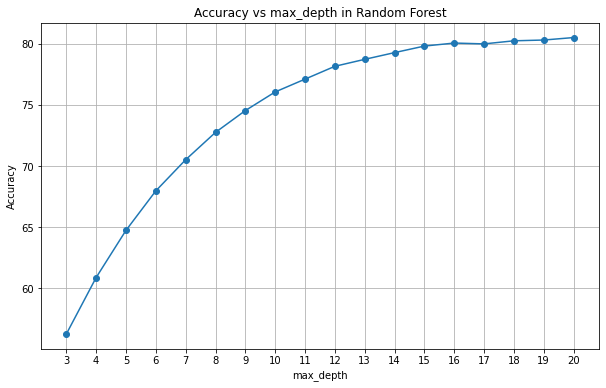

In [15]:
# Vary max_depth from 3 to 20
max_depth_range = range(3, 21)
accuracies = []

for max_depth in max_depth_range:
    # Train Random Forest model with current max_depth
    model = RandomForestRegressor(max_depth=max_depth, max_features='sqrt', bootstrap=True, random_state=42)
    model.fit(X_train, Y_train)
    
    # Evaluate model
    accuracy = evaluate(model, X_test, Y_test)
    accuracies.append(accuracy)

# Plot accuracy vs max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, accuracies, marker='o', linestyle='-')
plt.title('Accuracy vs max_depth in Random Forest')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(3, 21))
plt.show()